In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore') 
warnings.simplefilter("ignore", ConvergenceWarning)

## Data Cleaning

In [2]:
df = pd.read_csv('parkingLot.csv', dtype={'camera_id': str}) 

df_entry = df[df['camera_id'] == '001'].sort_values(by='vehicle_no')
df_entry.reset_index(drop = True, inplace = True)
# df_entry.to_csv('parkingLot_camera_001.csv', index=False)

df_exit = df[df['camera_id'] == '002'].sort_values(by='vehicle_no')
df_exit.reset_index(drop = True, inplace = True)
# df_exit.to_csv('parkingLot_camera_002.csv', index=False)

duplicates = df['vehicle_no'].value_counts()[df['vehicle_no'].value_counts()%2 != 0]
print(duplicates.shape[0])


dd3 = pd.DataFrame({
    'vehicle_no': ['MHWW1113', 'MHPY2628', 'MHBK0188', 'MHKA6372', 'MHYV2746', 'MHPH6142', 'MHSM0215', 'MHNO9764', 'MHCZ2221'],
    'timestamp': ['2024-10-19 14:00:00', '2024-11-09 14:00:00', '2024-10-07 14:20:00', '2024-10-26 17:20:00', '2024-11-09 13:00:00', '2024-09-28 14:00:00', '2024-09-30 05:40:00', '2024-09-14 15:20:00', '2024-10-05 17:00:00'],
    'camera_id': ['002', '002', '001', '002', '002', '002', '001', '001', '002']
})

unique_001 = df_entry[~df_entry['vehicle_no'].isin(df_exit['vehicle_no'])].sort_values(by='vehicle_no')
unique_002 = df_exit[~df_exit['vehicle_no'].isin(df_entry['vehicle_no'])].sort_values(by='vehicle_no')
Nan = df[pd.isna(df['vehicle_no'])].sort_values(by='camera_id')
Nan_001 = Nan[Nan['camera_id'] == '001'].sort_values(by = 'timestamp')
Nan_002 = Nan[Nan['camera_id'] == '002'].sort_values(by = 'timestamp')

filtered_dd13 = dd3[dd3['camera_id'] == '001']
updated_camera_001 = pd.concat([unique_001, filtered_dd13], ignore_index=True).sort_values(by='vehicle_no')
filtered_dd23 = dd3[dd3['camera_id'] == '002']
updated_camera_002 = pd.concat([unique_002, filtered_dd23], ignore_index=True).sort_values(by='vehicle_no')


# shape
print(Nan.shape[0])
print(Nan_001.shape[0],Nan_002.shape[0])
print(updated_camera_001.shape[0],updated_camera_002.shape[0])

# Save to new files
updated_camera_001.reset_index(drop=True, inplace=True)
updated_camera_001.reset_index(drop=True, inplace=True)
Nan_001.reset_index(drop=True, inplace=True)
Nan_002.reset_index(drop=True, inplace=True)
Nan.reset_index(drop= True, inplace = True)
# updated_camera_001.to_csv('unique_camera_001.csv', index=False)
# updated_camera_002.to_csv('unique_camera_002.csv', index=False)
# Nan_001.to_csv('Nan_001.csv', index = False)
# Nan_002.to_csv('Nan_002.csv', index = False)
# Nan.to_csv('Unique_NaN.csv', index= False)

1471
441
371 70
585 886


In [3]:
def is_similar(vn1, vn2):
    if len(vn1) != len(vn2):
        return False
    differences = sum(1 for a, b in zip(vn1, vn2) if a != b)
    return differences <= 1


pairs_same = []
paired_v2 = set()
count =0

for v1_row in updated_camera_001.itertuples(index=False):
    v1 = v1_row.vehicle_no
    v1_time = pd.to_datetime(v1_row.timestamp)
    
    for v2_row in updated_camera_002.itertuples(index=False):
        v2 = v2_row.vehicle_no
        v2_time = pd.to_datetime(v2_row.timestamp)
        if is_similar(v1, v2) and v1_time < v2_time:
            if v2 == 'MHOL4368':
                print(v1,v2)
            if v2 not in paired_v2:
                pairs_same.append((v1, v2))
                paired_v2.add(v2)
            break

# Convert pairs to DataFrame for better readability
pairs_df = pd.DataFrame(pairs_same, columns=['vehicle_no_001', 'vehicle_no_002'])

MHOL4378 MHOL4368
MHOV4368 MHOL4368


In [4]:
# Extract the vehicle_no from pairs_df
paired_001 = pairs_df['vehicle_no_001']
paired_002 = pairs_df['vehicle_no_002']

# Create new DataFrames excluding paired vehicle_no
remaining_001 = updated_camera_001[~updated_camera_001['vehicle_no'].isin(paired_001)].sort_values(by='timestamp')
remaining_002 = updated_camera_002[~updated_camera_002['vehicle_no'].isin(paired_002)].sort_values(by='timestamp')

# Save to new CSV files
remaining_002.reset_index(drop=True, inplace=True)
remaining_001.reset_index(drop=True, inplace=True)
# remaining_001.to_csv('remaining_unique_001.csv', index=False)
# remaining_002.to_csv('remaining_unique_002.csv', index=False)
print(remaining_001.shape[0],remaining_002.shape[0])

70 371


In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('parkingLot.csv', dtype= {'camera_id' : str})  # Replace with your actual file name

# Sort the DataFrame by 'vehicle_no'
df_sorted = df.sort_values(by='vehicle_no')

# Save the sorted DataFrame to a new CSV file (if needed)
df_sorted.reset_index(drop=True, inplace=True)
# df_sorted.to_csv('sorted_parkingLot.csv', index=False)  # Save the sorted file

In [6]:
                                # Delete a column by position (e.g., delete the 1st column, index 0)
Nan_001_copy = Nan_001.drop(Nan_001.columns[0], axis=1)

# Insert the first column from df2 at the 0th position in df1
Nan_001_copy.insert(0, 'vehicle_no', remaining_002.iloc[:, 0])  # Adding the first column of df2 at position 0

# Save the result to a new CSV file
# Nan_001_copy.to_csv('Nan001_with_vehicle_no.csv', index=False)

In [7]:
# Convert the 'timestamp' to datetime (without modifying df_entry)
df_entry_copy = df_entry.copy()
df_entry_copy['timestamp'] = pd.to_datetime(df_entry_copy['timestamp'], errors='coerce')

# Extract date and count vehicles entered per day
daily_counts = df_entry_copy.groupby(df_entry_copy['timestamp'].dt.date)['vehicle_no'].count().reset_index()
daily_counts.columns = ['date', 'vehicles_entered']

# Set date as index (optional)
daily_counts.set_index('date', inplace=True)

pd.set_option('display.max_rows', None)
# Calculate the sum of the 'vehicles_entered' column
total_vehicles_entered = daily_counts['vehicles_entered'].sum()
print(df_entry.shape[0])

# Print the total
print("Total vehicles entered:", total_vehicles_entered)
print(daily_counts) 

53347
Total vehicles entered: 52976
            vehicles_entered
date                        
2024-09-12               886
2024-09-13               809
2024-09-14               861
2024-09-15              1073
2024-09-16               843
2024-09-17               803
2024-09-18               940
2024-09-19               902
2024-09-20               789
2024-09-21               882
2024-09-22               859
2024-09-23               829
2024-09-24               831
2024-09-25               734
2024-09-26               755
2024-09-27               784
2024-09-28               789
2024-09-29               905
2024-09-30               803
2024-10-01               733
2024-10-02               993
2024-10-03               843
2024-10-04               821
2024-10-05               758
2024-10-06               855
2024-10-07               863
2024-10-08               749
2024-10-09               869
2024-10-10               821
2024-10-11               800
2024-10-12               809
2024-10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62755D+00    |proj g|=  3.53207D-01


 This problem is unconstrained.



At iterate    5    f=  4.47623D+00    |proj g|=  1.05411D-02

At iterate   10    f=  4.47041D+00    |proj g|=  1.23754D-02

At iterate   15    f=  4.46381D+00    |proj g|=  3.03042D-02

At iterate   20    f=  4.46055D+00    |proj g|=  4.80270D-03

At iterate   25    f=  4.45800D+00    |proj g|=  2.73377D-02

At iterate   30    f=  4.45498D+00    |proj g|=  1.29401D-02

At iterate   35    f=  4.45110D+00    |proj g|=  1.39125D-02

At iterate   40    f=  4.44842D+00    |proj g|=  6.85586D-03

At iterate   45    f=  4.44604D+00    |proj g|=  1.31972D-02

At iterate   50    f=  4.44351D+00    |proj g|=  1.16368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.63155D+00    |proj g|=  1.45679D-01

At iterate   15    f=  4.56447D+00    |proj g|=  1.09203D-01

At iterate   20    f=  4.55634D+00    |proj g|=  6.38418D-02

At iterate   25    f=  4.55187D+00    |proj g|=  7.65911D-02

At iterate   30    f=  4.54724D+00    |proj g|=  2.40922D-02

At iterate   35    f=  4.54068D+00    |proj g|=  1.09239D-01

At iterate   40    f=  4.52954D+00    |proj g|=  3.35360D-02

At iterate   45    f=  4.52654D+00    |proj g|=  1.66638D-02

At iterate   50    f=  4.52480D+00    |proj g|=  5.64069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55   

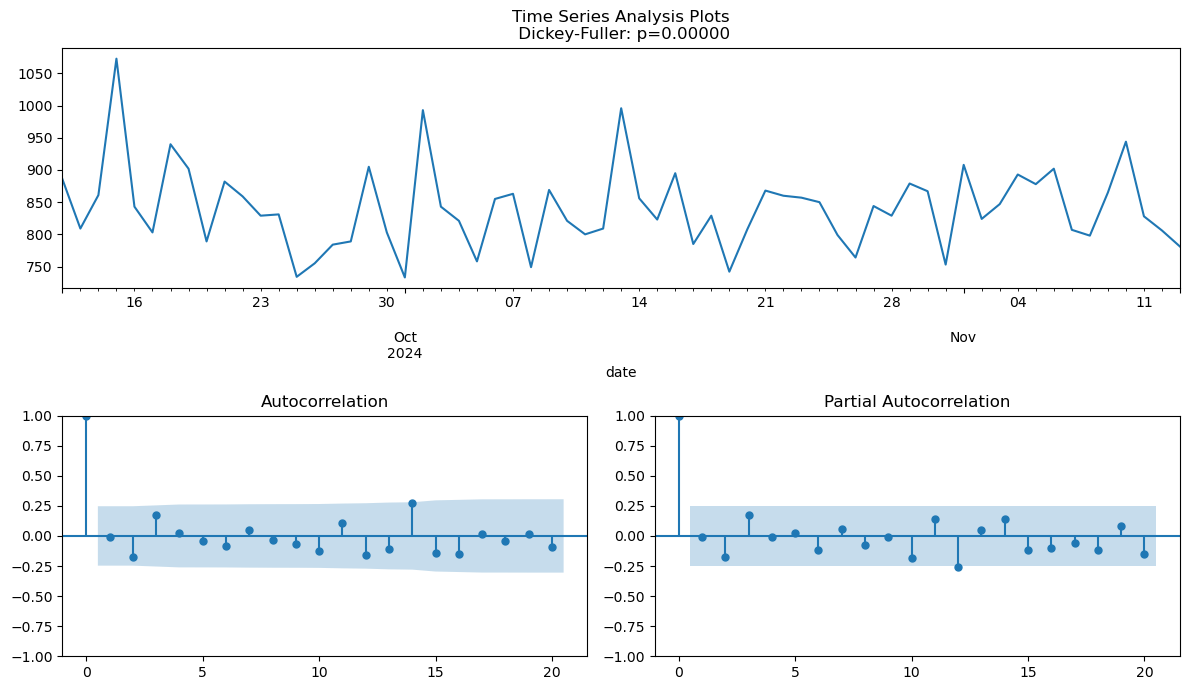

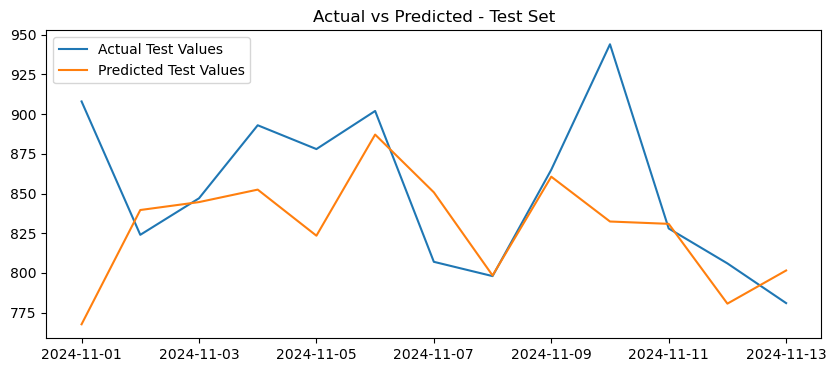

MAPE: 0.04, MASE: 0.50
Next 7-day Forecast:
 2024-11-14    748.542643
2024-11-15    866.704506
2024-11-16    845.137091
2024-11-17    803.917823
2024-11-18    845.746673
2024-11-19    847.346288
2024-11-20    804.357235
Freq: D, Name: predicted_mean, dtype: float64


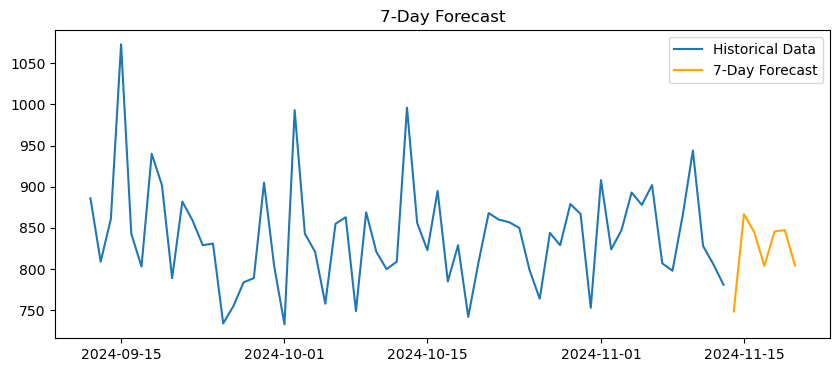

In [8]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

# Ensure your data has a DateTime index
daily_counts = daily_counts.asfreq('D')  # This assumes daily_counts is already a DataFrame
tsplot(daily_counts['vehicles_entered'], lags=20)


# Split into training and testing sets
train_size = int(len(daily_counts) * 0.8)  # 80% for training
train, test = daily_counts.iloc[:train_size], daily_counts.iloc[train_size:]

# SARIMAX Model fitting
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data characteristics
model = SARIMAX(train['vehicles_entered'], order=(7, 0, 10), seasonal_order=(1, 1, 2, 12))  # Example parameters
model_fit = model.fit()

# Model for full dataset to make future predictions
full_model = SARIMAX(daily_counts['vehicles_entered'], order=(7, 0, 10), seasonal_order=(1, 1, 2, 12))
full_model_fit = full_model.fit()

# Make predictions for the test set
if not test.empty:
    test_forecast = model_fit.forecast(steps=len(test))
    # Plotting forecast vs actual values
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test['vehicles_entered'], label='Actual Test Values')
    plt.plot(test.index, test_forecast, label='Predicted Test Values')
    plt.title('Actual vs Predicted - Test Set')
    plt.legend()
    plt.show()

    # Calculate metrics
    mape = mean_absolute_percentage_error(test['vehicles_entered'], test_forecast)
    mase = mean_absolute_error(test['vehicles_entered'], test_forecast) / np.mean(np.abs(np.diff(train['vehicles_entered'])))
    print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast = full_model_fit.forecast(steps=forecast_steps)
print("Next 7-day Forecast:\n", future_forecast)

# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(daily_counts['vehicles_entered'], label='Historical Data')
plt.plot(pd.date_range(daily_counts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps), future_forecast, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.legend()
plt.show()